In [1]:
from IPython.display import Image

## Question 1. Run Mage

First, let's run Mage with Docker Compose. Follow the quick start guideline. 

What's the version of Mage we run? 

(You can see it in the UI)

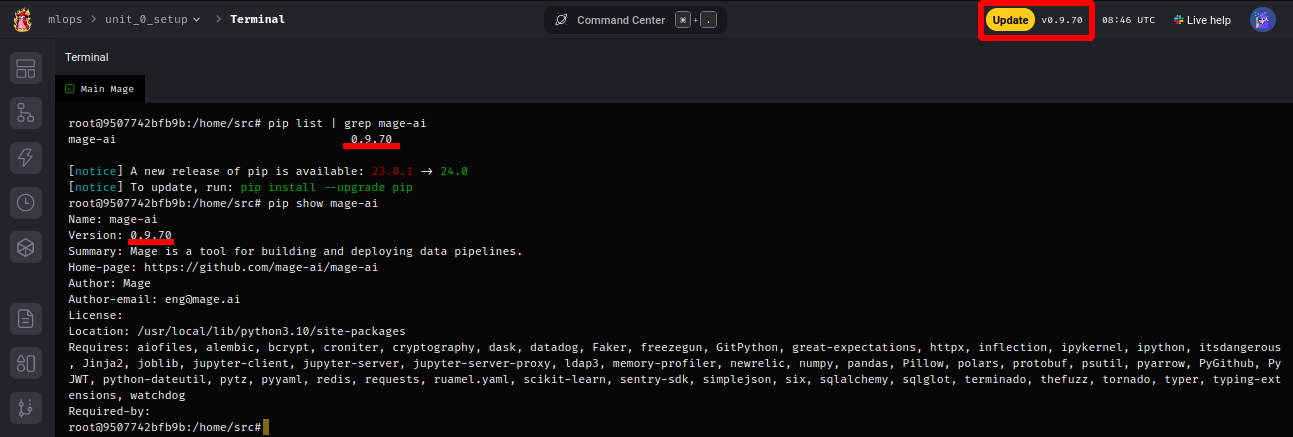

In [3]:

Image(filename='./screenshots/screenshot_Q1_hw3.png')

## ***Answer for Q1:==*** 0.9.70

## Question 2. Creating a project

Now let's create a new project. We can call it "homework_03", for example.

How many lines are in the created `metadata.yaml` file? 

- 35
- 45
- 55
- 65

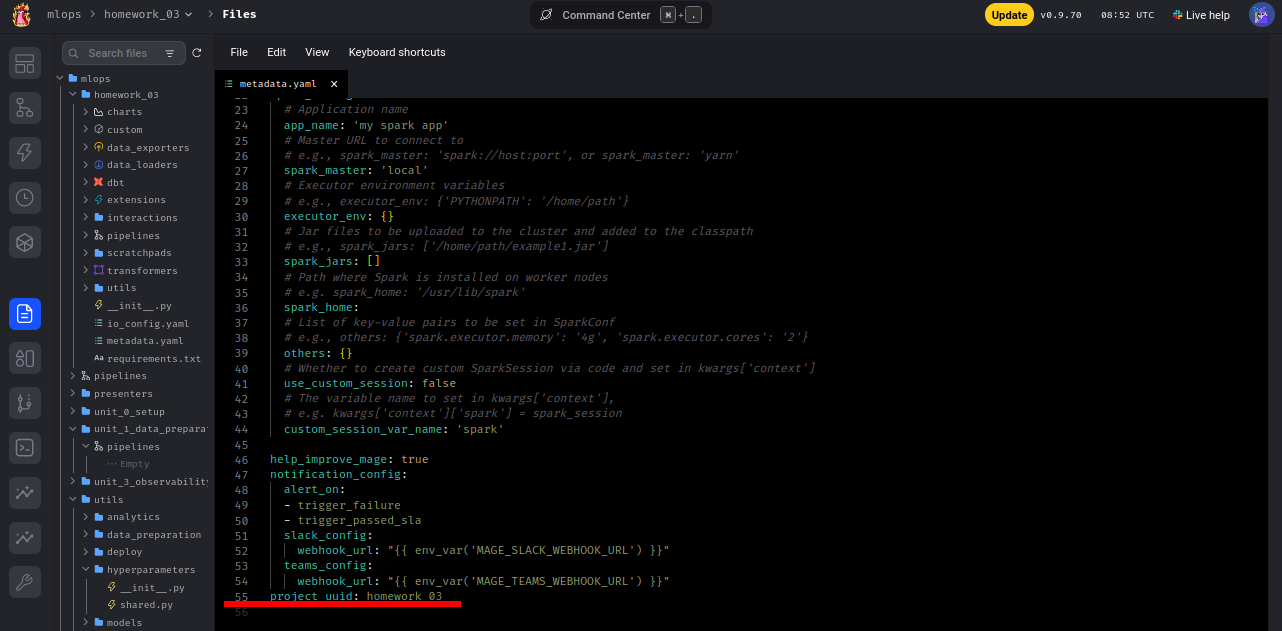

In [4]:
Image(filename='./screenshots/screenshot_Q2_hw3.png')

## ***Answer for Q2:==*** 55

## Question 3. Creating a pipeline

Let's create an ingestion code block.

In this block, we will read the March 2023 Yellow taxi trips data. We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

How many records did we load? 

- 3,003,766
- 3,203,766
- 3,403,766
- 3,603,766

code for ingest.py
```python
import requests
from io import BytesIO
from typing import List
import gc

import pandas as pd

if 'data_loader' not in globals():
    from mage_ai.data_preparation.decorators import data_loader

LOAD_COLUMNS = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_distance' ]

@data_loader
def ingest_files(**kwargs) -> pd.DataFrame:
    dfs: List[pd.DataFrame] = []

    for year, months in [(2023, (3, 4))]:
        for i in range(*months):
            print(year, i)
            response = requests.get(
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_'
                f'{year}-{i:02d}.parquet'
            )

            if response.status_code != 200:
                raise Exception(response.text)

            df = pd.read_parquet(BytesIO(response.content), columns=LOAD_COLUMNS)
            dfs.append(df)
            del df
            gc.collect() 

    max_size_df = kwargs.get('max_size_df')
    if max_size_df > 0:
        df = pd.concat(dfs)[:max_size_df]
    else:
        df = pd.concat(dfs)

    print(len(df))
    return df
```

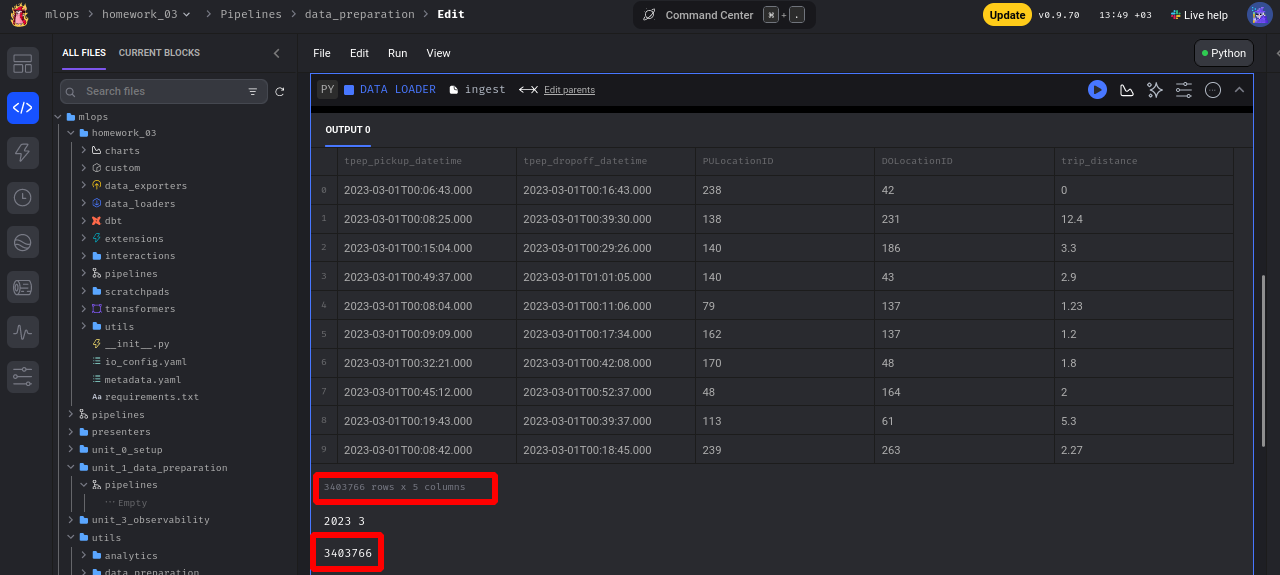

In [3]:
Image(filename='./screenshots/screenshot_Q3_hw3.png')

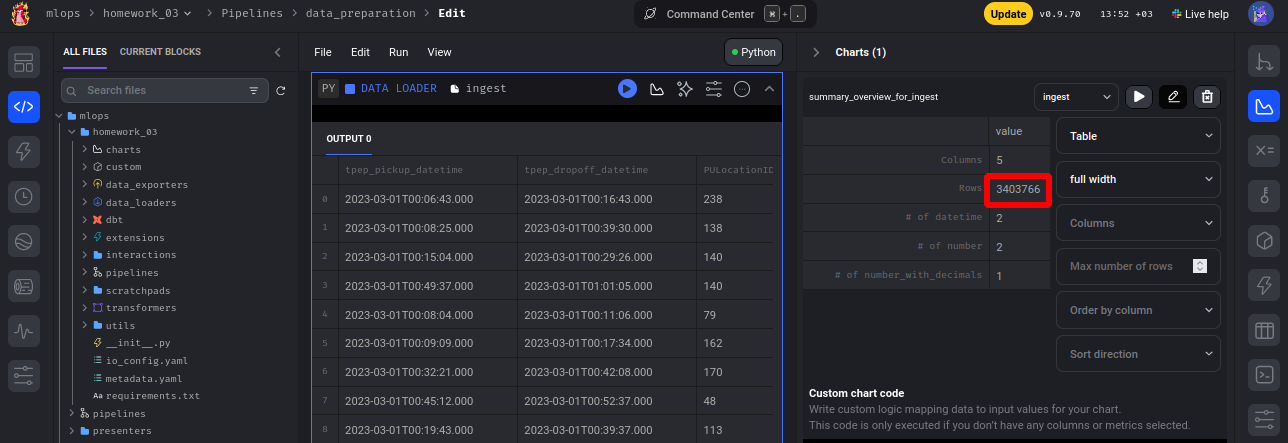

In [4]:
Image(filename='./screenshots/screenshot_Q3_hw3_2.png')

## ***Answer for Q3:==*** 3,403,766

## Question 4. Data preparation


Let's use the same logic for preparing the data we used previously. We will need to create a transformer code block and put this code there.

This is what we used (adjusted for yellow dataset):

```python
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df
```

Let's adjust it and apply to the data we loaded in question 3. 

What's the size of the result? 


- 2,903,766
- 3,103,766
- 3,316,216
- 3,503,766

code for clean_outliers
```python
import pandas as pd

from mlops.utils.data_preparation.hw3_cleaning import clean

if 'transformer' not in globals():
    from mage_ai.data_preparation.decorators import transformer


@transformer
def transform(
    df: pd.DataFrame
) -> pd.DataFrame:

    df = clean(df)

    return df
```

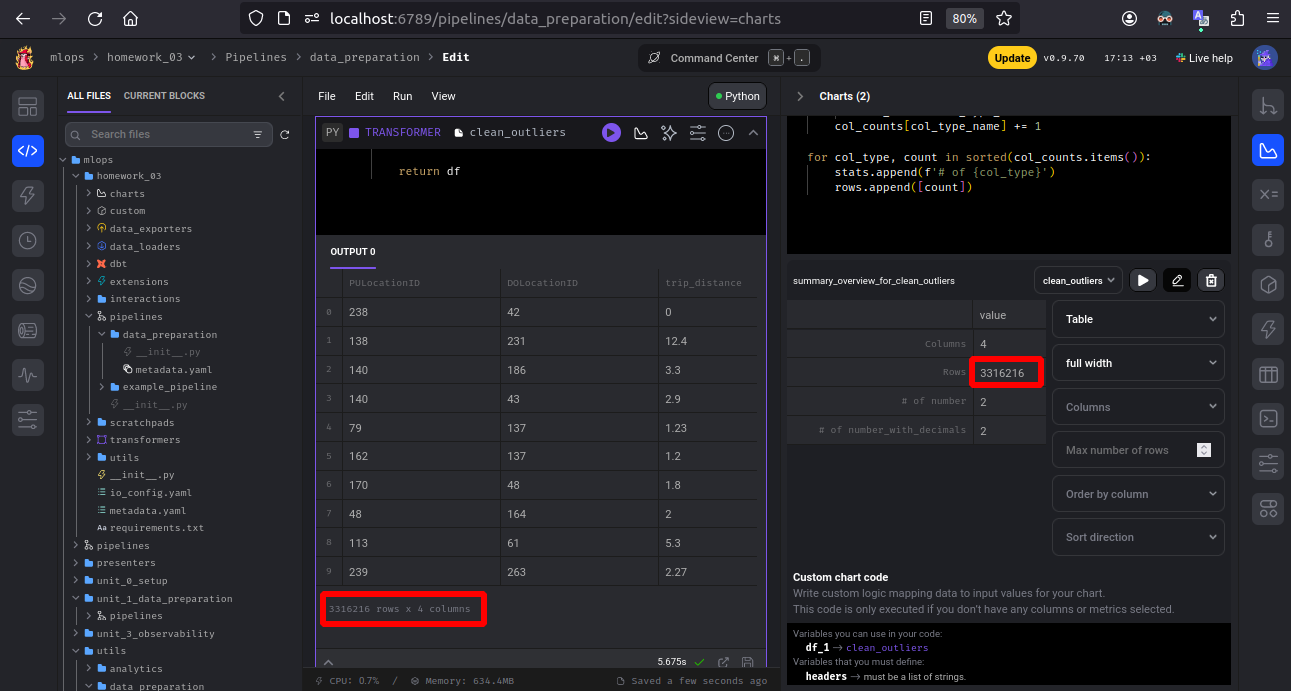

In [2]:
Image(filename='./screenshots/screenshot_Q4_hw3.png')

## ***Answer for Q4:==*** 3,316,216

## Question 5. Train a model

We will now train a linear regression model using the same code as in homework 1

* Fit a dict vectorizer
* Train a linear regression with default parameres 
* Use pick up and drop off locations separately, don't create a combination feature

Let's now use it in the pipeline. We will need to create another transformation block, and return both the dict vectorizer and the model

What's the intercept of the model? 

Hint: print the `intercept_` field in the code block

- 21.77
- 24.77
- 27.77
- 31.77


code for load models
```python
from typing import Dict, List, Tuple

if 'custom' not in globals():
    from mage_ai.data_preparation.decorators import custom


@custom
def models(*args, **kwargs) -> Tuple[List[str], List[Dict[str, str]]]:
    """
    models: comma separated strings
        linear_model.LinearRegression
    """
    model_names: str = kwargs.get(
        'models', 'linear_model.LinearRegression'
    )
    child_data: List[str] = [
        model_name.strip() for model_name in model_names.split(',')
    ]
    child_metadata: List[Dict] = [
        dict(block_uuid=model_name.split('.')[-1]) for model_name in child_data
    ]

    return child_data, child_metadata
```

code for default_training
```python
from typing import Callable, Dict, Tuple, Union

from pandas import Series
from scipy.sparse._csr import csr_matrix
from sklearn.base import BaseEstimator

from mlops.utils.models.hw3_sklearn import load_class, train_model

if 'transformer' not in globals():
    from mage_ai.data_preparation.decorators import transformer


@transformer
def default_training(
    training_set: Dict[str, Union[Series, csr_matrix]],
    model_class_name: str,
    *args,
    **kwargs,
) -> Tuple[
    BaseEstimator,
    Dict[str, Union[bool, float, int, str]],
    csr_matrix,
    Series,
    Callable[..., BaseEstimator],
]:

    X, y, _ = training_set['encoder']
    
    model_class = load_class(model_class_name)
    model, metrics, y_pred = train_model(
        model_class(),
        X_train=X,
        y_train=y,
        X_val=X,
        y_val=y
    )

    parameters = model.get_params()    
    intercept = model.intercept_ if hasattr(model, 'intercept_') else 'N/A'
    alpha = model.alpha if hasattr(model, 'alpha') else 'N/A'

    parameters['intercept'] = intercept
    parameters['alpha'] = alpha
    parameters['mse_train'] = metrics['mse']
    parameters['rmse_train'] = metrics['rmse']
    
    
    return model, parameters, X, y, dict(cls=model_class, name=model_class_name)
```


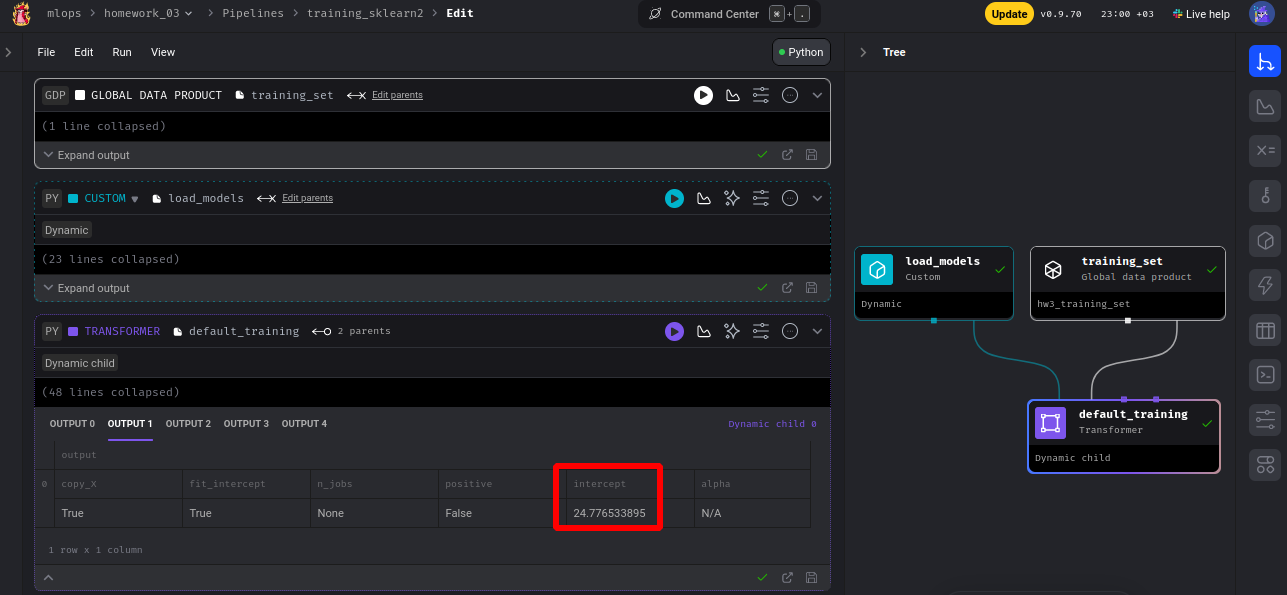

In [2]:
Image(filename='./screenshots/screenshot_Q5_hw3.png')

## ***Answer for Q5:==*** 24.77

## Question 6. Register the model 

The model is trained, so let's save it with MLFlow.

If you run mage with docker-compose, stop it with Ctrl+C or 

```bash
docker-compose down
```

Let's create a dockerfile for mlflow, e.g. `mlflow.dockerfile`:

```dockerfile
FROM python:3.10-slim

RUN pip install mlflow==2.12.1

EXPOSE 5000

CMD [ \
    "mlflow", "server", \
    "--backend-store-uri", "sqlite:///home/mlflow/mlflow.db", \
    "--host", "0.0.0.0", \
    "--port", "5000" \
]
```

And add it to the docker-compose.yaml:

```yaml
  mlflow:
    build:
      context: .
      dockerfile: mlflow.dockerfile
    ports:
      - "5000:5000"
    volumes:
      - "${PWD}/mlflow:/home/mlflow/"
    networks:
      - app-network
```

Note that `app-network` is the same network as for mage and postgre containers.
If you use a different compose file, adjust it.

We should already have `mlflow==2.12.1` in requirements.txt in the mage project we created for the module. If you're starting from scratch, add it to your requirements.

Next, start the compose again and create a data exporter block.

In the block, we

* Log the model (linear regression)
* Save and log the artifact (dict vectorizer)

If you used the suggested docker-compose snippet, mlflow should be accessible at `http://mlflow:5000`.

Find the logged model, and find MLModel file. What's the size of the model? (`model_size_bytes` field):

* 14,534
* 9,534
* 4,534
* 1,534

> Note: typically we do two last steps in one code block 

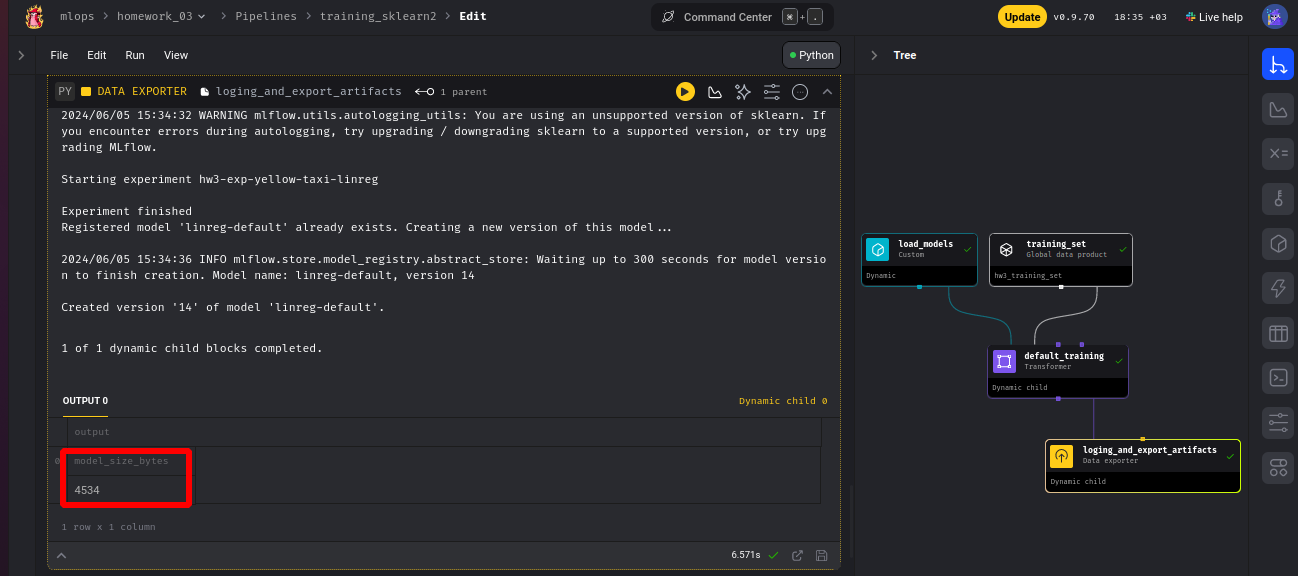

In [2]:
Image(filename='./screenshots/screenshot_Q6_hw3.png')

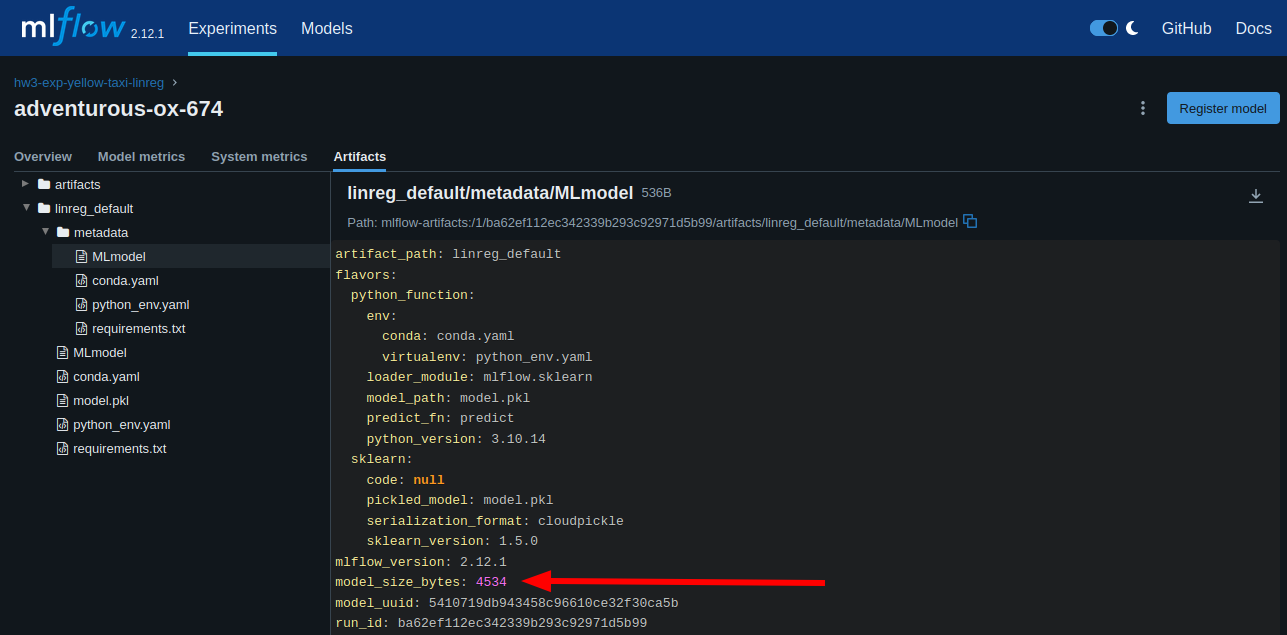

In [3]:
Image(filename='./screenshots/screenshot_Q6_hw3_2.png')

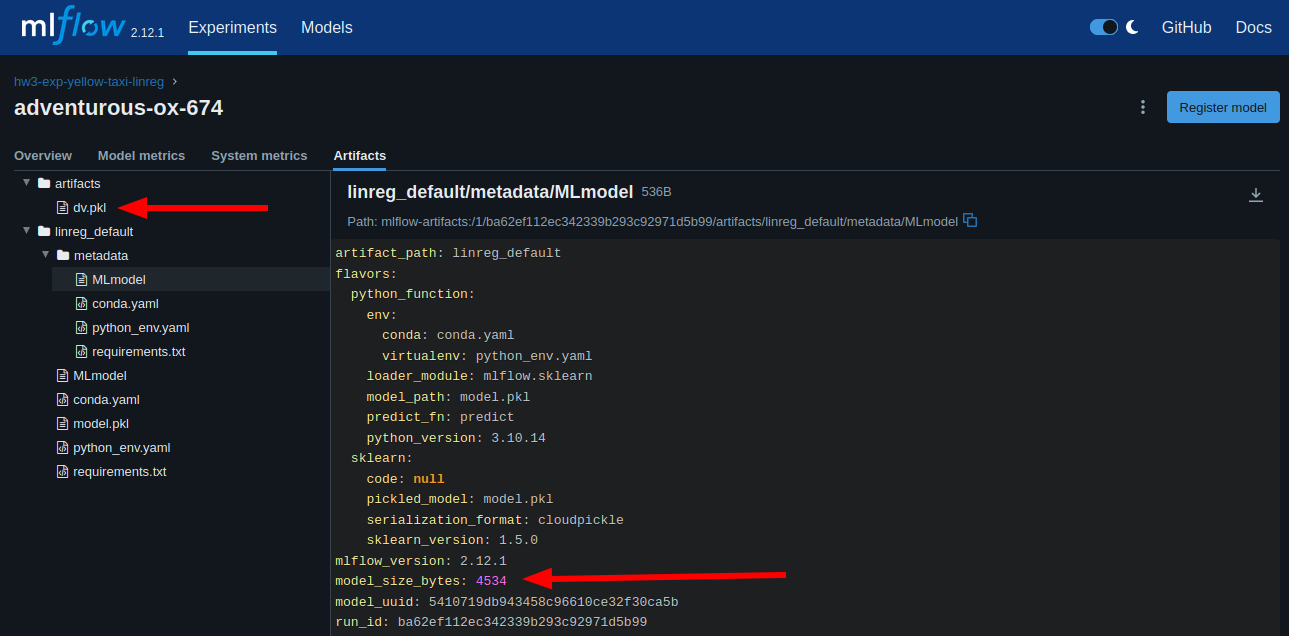

In [4]:
Image(filename='./screenshots/screenshot_Q6_hw3_3.png')

## ***Answer for Q6:==*** 4534